In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# CONFIG
file_path = r"RTFED_BASIC.xlsx"
sheet_data = pd.read_excel(file_path, sheet_name=None)

figsize_small = (2.5, 1.88)
dpi_val = 220
colors = {"Free_feed": "dodgerblue", "FR1": "dimgray"}
jitter_strength = 0.03
sns.set_style("white")

summary = []
circadian_ff, circadian_fr = [], []
learning_curves = {}

# DATA PROCESSING
for sheet_name, df in sheet_data.items():
    df["Timestamp"] = pd.to_datetime(df["MM/DD/YYYY hh:mm:ss.SSS"])
    df = df.sort_values("Timestamp")
    mouse_id = sheet_name.split("_")[-1]

    # pellet summary & circadian
    for mode in ["Free_feed", "FR1"]:
        pellets = df[(df["Session_type"] == mode) & (df["Event"] == "Pellet")].copy()
        if pellets.empty:
            summary.append({"Mouse_ID": mouse_id, "Mode": mode,
                            "Pellets": 0, "Snacks": 0, "Meals": 0, "Feasts": 0})
        else:
            pellets["Time_Diff"] = pellets["Timestamp"].diff().dt.total_seconds().fillna(9999)
            pellets["Cluster"] = (pellets["Time_Diff"] > 60).cumsum()
            sizes = pellets.groupby("Cluster").size()
            summary.append({
                "Mouse_ID": mouse_id, "Mode": mode,
                "Pellets": len(pellets),
                "Snacks": (sizes == 1).sum(),
                "Meals": ((sizes >= 2) & (sizes <= 5)).sum(),
                "Feasts": (sizes > 5).sum()
            })
            hourly = pellets["Timestamp"].dt.hour.value_counts().reindex(range(24), fill_value=0).values
            (circadian_ff if mode == "Free_feed" else circadian_fr).append(hourly)

    # learning curves, FR1 only, dark phase 12–23h
    fr = df[df["Session_type"] == "FR1"].copy()
    if not fr.empty:
        fr["HourBin"] = fr["Timestamp"].dt.floor("H")
        pokes = (fr.groupby("HourBin")[["Left_Poke_Count", "Right_Poke_Count"]]
                   .max().diff().fillna(0))
        pokes["Hour"] = pokes.index.hour
        pokes = pokes[(pokes["Hour"] >= 12) & (pokes["Hour"] <= 23)]
        learning_curves[mouse_id] = pokes

summary_df = pd.DataFrame(summary)




C:\Users\hta031\AppData\Local\Temp\ipykernel_41924\2065443706.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fr["HourBin"] = fr["Timestamp"].dt.floor("H")
C:\Users\hta031\AppData\Local\Temp\ipykernel_41924\2065443706.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fr["HourBin"] = fr["Timestamp"].dt.floor("H")
C:\Users\hta031\AppData\Local\Temp\ipykernel_41924\2065443706.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fr["HourBin"] = fr["Timestamp"].dt.floor("H")
C:\Users\hta031\AppData\Local\Temp\ipykernel_41924\2065443706.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  fr["HourBin"] = fr["Timestamp"].dt.floor("H")
C:\Users\hta031\AppData\Local\Temp\ipykernel_41924\2065443706.py:50: FutureWarning: 'H' is deprecated and will be removed in a future versio

Heat shape: (24, 24)
n_ff: 12 n_fr: 12
y_ff: 5.5 y_fr: 17.5


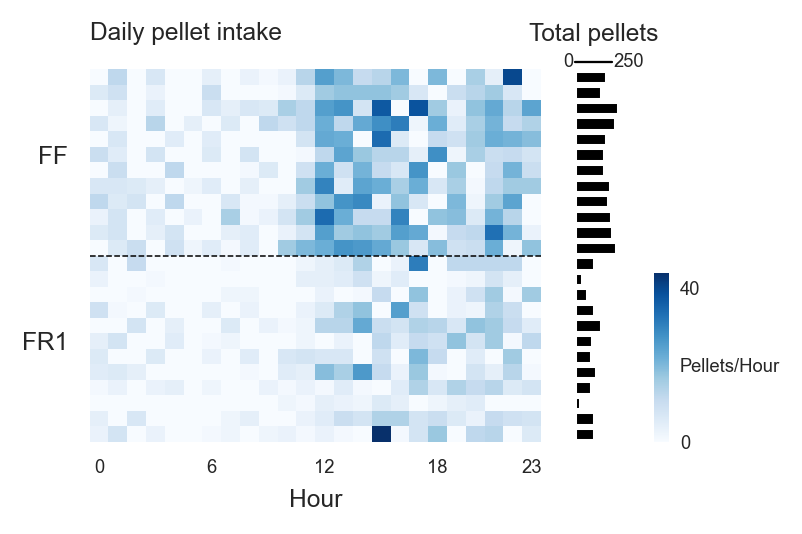

In [2]:

try:
    heat = np.vstack(circadian_ff + circadian_fr)
    n_ff, n_fr = len(circadian_ff), len(circadian_fr)
except NameError:
    circadian_ff = [np.random.rand(5, 24)]  # 5 rows for FF
    circadian_fr = [np.random.rand(5, 24)]  # 5 rows for FR1
    heat = np.vstack(circadian_ff + circadian_fr)
    n_ff, n_fr = len(circadian_ff), len(circadian_fr)
    dpi_val = 4800

# Verify data
print("Heat shape:", heat.shape)
print("n_ff:", n_ff, "n_fr:", n_fr)

y_ff = (n_ff - 1) / 2
y_fr = n_ff + (n_fr - 1) / 2
print("y_ff:", y_ff, "y_fr:", y_fr)

sums = heat.sum(axis=1)

fig = plt.figure(figsize=(3.4, 2.2), dpi=dpi_val)
gs = fig.add_gridspec(2, 3, width_ratios=[6, 0.6, 0.2])
ax_hm = fig.add_subplot(gs[:,0])
ax_cb = fig.add_subplot(gs[0, 2])
ax_bar = fig.add_subplot(gs[:,1])  # No sharey

# Heatmap with yticklabels=False
sns.heatmap(heat, cmap="Blues", cbar=True, ax=ax_hm,
            xticklabels=False, yticklabels=False, cbar_ax=ax_cb)

# x-axis hour ticks
# ax_hm.set_xticks(np.arange(24) + 0.5)
# ax_hm.set_xticklabels(np.arange(24), rotation=45, ha='right', fontsize=5)
# ax_hm.tick_params(axis='x', length=2)

# Custom tick positions for 0, 6, 12, 18, and 23 hours
xtick_hours = [0, 6, 12, 18, 23]
xtick_positions = np.array(xtick_hours) + 0.5  # align to cell centers

ax_hm.set_xticks(xtick_positions)
ax_hm.set_xticklabels(xtick_hours, fontsize=6) 
ax_hm.tick_params(axis='x', length=2)



# y-labels and divider
ax_hm.set_yticks([y_ff, y_fr])
ax_hm.set_yticklabels(["FF", "FR1"], fontsize=8, rotation=0)
ax_hm.axhline(n_ff, color='black', linestyle='--', linewidth=0.5)
ax_hm.set_title("Daily pellet intake", fontsize=8, loc='left', x=0.0, y=1.03)  # Title aligned to left
ax_hm.set_xlabel("Hour", fontsize=8)
# Move colorbar down so its "0" aligns with the x-axis of the heatmap
# Get the position of the heatmap axis
hm_pos = ax_hm.get_position()
# Get the position of the colorbar axis
cb_pos = ax_cb.get_position()

# Set new y0 for colorbar: align with heatmap's x-axis (bottom)
cb_new_y0 = hm_pos.y0
cb_new_y1 = cb_new_y0 + cb_pos.height  # keep same height

# Set new position for colorbar axis
ax_cb.set_position([cb_pos.x0, cb_new_y0, cb_pos.width, cb_pos.height])

# Smaller colorbar tick labels
ax_cb.tick_params(labelsize=6, length=0)
ax_cb.set_yticks([0, 20, 40], labels=["0", "Pellets/Hour", "40"])



# Bar plot with inverted y-axis and purple color
ax_bar.barh(np.arange(len(sums)), sums, height=0.8, color='black')
ax_bar.invert_yaxis()  # Invert y-axis to match heatmap (FF on top, FR1 on bottom)
ax_bar.set_yticks([])
ax_bar.set_xticks([])  # No x-ticks on bar plot
#ax_bar.set_xlabel("Pellets", fontsize=8)
ax_bar.set_ylim(23.5,-0.5)
ax_bar.plot([0, 250], [-1, -1], color='black', lw=0.75, clip_on= False)  # Add vertical line at x=0 ############################################
ax_bar.text(-10, -1, "0", fontsize=6, ha='right', va='center')  # Add text at x=0 ##########################################
ax_bar.text(260, -1, "250", fontsize=6, ha='left', va='center')  # Add text at x=0 ##########################################
ax_bar.text(125, -2, "Total pellets", fontsize=8, ha='center', va='bottom')  # Add text at x=0 ##########################################



ax_bar.tick_params(axis='x', labelsize=6,  length=4)  # Ensure x-ticks are visible 

sns.despine(ax=ax_hm, left= True, bottom= True) 
sns.despine(ax=ax_bar, left=True, bottom=True)  # Disable left spine for bar plot
sns.despine(ax=ax_cb, left= True, bottom= True)  # Disable left spine for colorbar
#plt.tight_layout()
#plt.savefig("../plots_and_figs/heatmap_plot4_v3.tif", dpi=dpi_val, bbox_inches="tight")  
plt.show()






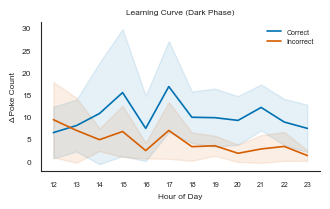

In [4]:
# PLOT 2: Learning Curve – Correct vs Incorrect Δ Poke Count
hours = np.arange(12, 24)
n = len(learning_curves)
left_mat  = np.full((n, len(hours)), np.nan)
right_mat = np.full((n, len(hours)), np.nan)
for i, df in enumerate(learning_curves.values()):
    for j, h in enumerate(hours):
        if h in df["Hour"].values:
            r = df.query("Hour==@h").iloc[0]
            left_mat[i, j]  = r["Left_Poke_Count"]
            right_mat[i, j] = r["Right_Poke_Count"]

mean_l = np.nanmean(left_mat, axis=0)
std_l  = np.nanstd(left_mat,  axis=0)
mean_r = np.nanmean(right_mat,axis=0)
std_r  = np.nanstd(right_mat, axis=0)

fig, ax = plt.subplots(figsize=figsize_small, dpi=dpi_val)
ax.plot(hours, mean_l, color="#0072B2", label="Correct", linewidth=1.2)
ax.fill_between(hours, mean_l - std_l, mean_l + std_l, alpha=0.1, color="#0072B2")
ax.plot(hours, mean_r, color="#D55E00", label="Incorrect", linewidth=1.2)
ax.fill_between(hours, mean_r - std_r, mean_r + std_r, alpha=0.1, color="#D55E00")
ax.set_title("Learning Curve (Dark Phase)", fontsize=6)
ax.set_xlabel("Hour of Day", fontsize=6)
ax.set_ylabel("Δ Poke Count", fontsize=6)
ax.set_xticks(hours)
ax.tick_params(axis='x', labelsize=5, length=4)
ax.tick_params(axis='y', labelsize=6)
ax.legend(fontsize=5, frameon=False)
sns.despine(); plt.tight_layout(); plt.show()

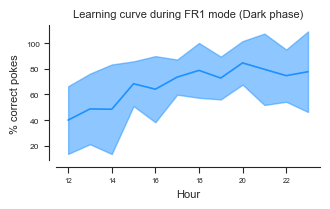

In [5]:
import numpy as np
import matplotlib.pyplot as plt
hours = np.arange(12, 24)
try:
    perf_mat = left_mat / (left_mat + right_mat)
    mean_perf = np.nanmean(perf_mat, axis=0)
    std_perf = np.nanstd(perf_mat, axis=0)
except NameError:
    hours = np.arange(24)
    perf_mat = np.random.rand(5, 24)
    mean_perf = np.nanmean(perf_mat, axis=0)
    std_perf = np.nanstd(perf_mat, axis=0)
    figsize_small = (3.4, 2.2)
    dpi_val = 100

fig, ax = plt.subplots(figsize=figsize_small, dpi=dpi_val)
ax.plot(hours, mean_perf * 100, linewidth=1.2, color="dodgerblue")
ax.fill_between(hours,
                (mean_perf - std_perf) * 100,
                (mean_perf + std_perf) * 100,
                color="dodgerblue", alpha=0.5)

ax.set_title("Learning curve during FR1 mode (Dark phase)", fontsize=8)
ax.set_xlabel("Hour", fontsize=8)
ax.set_ylabel("% correct pokes", fontsize=8)

# --> TICKS ONLY ON BOTTOM AND LEFT
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.tick_params(axis='x', labelsize=5, length=4, top=False)
ax.tick_params(axis='y', labelsize=6, left=True, right=False)

# --> HIDE TOP & RIGHT SPINES
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --> OFFSET BOTTOM & LEFT SPINES SO THEY DON'T MEET
offset = 5  # points
ax.spines['bottom'].set_position(('outward', offset))
ax.spines['left'].set_position(('outward', offset))

plt.tight_layout()
#plt.savefig("../plots_and_figs/performance_curve_V2.pdf", dpi=dpi_val, bbox_inches="tight")
plt.show()
